In [2]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
#Open the csv file containing information on SM particles
df = pd.read_csv('ParticleList.csv')

#Display the head
display(df.head())

,Flavour,States,Color,Type,Mass,Unnamed: 5
0,1,1,1,meson,134.97660,NaN
1,2,1,1,meson,139.57018,NaN
2,2,1,1,meson,493.67700,NaN
3,2,1,1,meson,497.61400,NaN
4,2,1,1,meson,497.61400,NaN


In [5]:
#Display the dataset description
df.describe()

,Flavour,States,Color,Mass,Unnamed: 5
count,261.000000,261.000000,261.000000,261.000000,0.0
mean,1.892720,3.900383,1.045977,3841.271313,NaN
std,0.551209,2.778634,0.300309,14959.422844,NaN
min,1.000000,1.000000,1.000000,0.511000,NaN
25%,2.000000,2.000000,1.000000,1510.000000,NaN
50%,2.000000,3.000000,1.000000,1869.610000,NaN
75%,2.000000,5.000000,1.000000,2250.000000,NaN
max,3.000000,16.000000,3.000000,173070.000000,NaN


In [8]:
#Renamed the 'Unnamed: 5' column into 'Degree'
df.rename(columns={'Unnamed: 5':'Degree'}, inplace=True)

#Fill the column with actual degree of freedom (dof) of the particles
#The contribution come from the number of flavour, number of possibl states, and colors
df['Degree'] = df['Flavour'] * df['States'] * df['Color']

#List containing the possible type name of the particles
names = ['meson', 'baryon', 'quark', 'lepton', 'boson']

display(df.head())

,Flavour,States,Color,Type,Mass,Degree
0,1,1,1,meson,134.97660,1
1,2,1,1,meson,139.57018,2
2,2,1,1,meson,493.67700,2
3,2,1,1,meson,497.61400,2
4,2,1,1,meson,497.61400,2


Here are the general formulas for the effective dof of individual particle

\begin{align}
g_{*n,i} &= \frac{g_i}{2\zeta(3)} \int_{x_i}^{\infty}\frac{x\sqrt{x^2 - x_i^2}}{e^x \pm 1} ~dx\\
g_{*\epsilon,i} &= \frac{15g_i}{\pi^4} \int_{x_i}^{\infty}\frac{x^2\sqrt{x^2 - x_i^2}}{e^x \pm 1} ~dx\\
g_{*p,i} &= \frac{15g_i}{\pi^4} \int_{x_i}^{\infty}\frac{\left(x^2 - x_i^2\right)^{3/2}}{e^x \pm 1} ~dx\\
g_{*s,i} &= \frac{3 g_{*\epsilon, i} + g_{*p, i}}{4}
\end{align}

The integral can be modified to always run from zero to infinity by changing the variable, $x \rightarrow x + x_i$. This led to $x^2 - x_i^2 = (x - x_i)(x + x_i) \rightarrow x(x + 2x_i)$ and $\exp(x)\rightarrow \exp(x + x_i)$

\begin{align}
g_{*n,i} &= \frac{g_i}{2\zeta(3)} \int_{0}^{\infty}\frac{(x + x_i)\sqrt{x (x + 2x_i)}}{e^{x + x_i} \pm 1} ~dx\\
g_{*\epsilon,i} &= \frac{15g_i}{\pi^4} \int_{0}^{\infty}\frac{(x + x_i)^2\sqrt{x (x + 2x_i)}}{e^{x + x_i} \pm 1} ~dx\\
g_{*p,i} &= \frac{15g_i}{\pi^4} \int_{0}^{\infty}\frac{\left(x (x + 2x_i)\right)^{3/2}}{e^{x + x_i} \pm 1} ~dx\\
g_{*s,i} &= \frac{3 g_{*\epsilon, i} + g_{*p, i}}{4}
\end{align}

The function $\exp(x + x_i)$ in $\frac{1}{e^{x+x_i} \pm 1}$ is numerically sensitive in the regime $x \rightarrow \infty$ and may pose problem during the numerical integration. To prevent that, we write them instead as
\begin{equation*}
\frac{1}{e^{x+x_i} \pm 1} = \frac{e^{-(x + x_i)}}{1 \pm e^{-(x + x_i)}}
\end{equation*}
which now is written in terms of $\exp(-(x + x_i))$, which goes to zero (stable) when $x \rightarrow \infty$.

In [15]:
#General formula for the integrand of the effective dof associated to entropy
def f(x, x0, cons):
    gs = (3 * ((x + x0)**2) * np.sqrt(x * (x + 2 * x0)) + (x * (x + 2 * x0))**(3/2))
    gs *= np.exp(- x - x0)/ (1 + cons * np.exp(- x - x0))
    return gs


In [16]:
#General formula for calculating effective dof of most of the particle
def degrees(dof, mass, temp, type, transition):
    #Defining x_i = m/T
    x0 = mass/temp

    #Initialising a variable to contain the resulting dof
    results = 0

    for name in names:
        x0ma = x0[type == name]
        dofm = dof[type == name]

        #Assigning constant in the integrand denuminator
        # +1 for fermion and -1 for boson
        if name in ['baryon', 'quark', 'lepton']:
            cons = 1
        else:
            cons = -1

        #Emulating the QCD transition
        #Mesons and baryons are ignored for T > T_trans
        if (name in ['meson', 'baryon']) & (temp > transition) :
            results += 0
        #While quarks are ignored for T < T_trans
        elif (name == 'quark') & (temp < transition):
            results += 0
        #Calculating and summing over the effective dof for relevant particles
        else:
            y = [quad(f, 0, np.inf, args=(x0m, cons,))[0] for x0m in x0ma]
            results += np.sum((dofm/(np.pi**4)) * (15/4) * y)
    
    return results

The gluons and quarks present in the particle contents when $T > T_{trans}$. Below the transition temperature, they are bounded inside various hadrons. This is emulated in above lines (for hadrons and quarks) and below (for gluons).

Left-handed neutrinos provide half the dof of leptons, $g_{\nu} = 5.25$. However, they decoupled from the thermal bath at temperature about $\sim 1 MeV$ while still relativistic. During this time, they still contributes to the total effective dof and have the same temperature as the thermal bath, $T_\nu = T_{\gamma}$, where the thermal bath consists of remaining relativistic particles, photons (g_{\gamma} = 2) and electron-positron (g_{e} = 4 \times 7/8 = 3.5). However, below $1 MeV$, the electron and positron starts annihilating into photons, changing both the thermal bath's temperature and effective dof.
\begin{align*}
g_{> 1 \text{ MeV}}T_{\gamma, > 1 \text{ MeV}}^4 &= g_{< 1 \text{ MeV}}T_{\gamma, < 1 \text{ MeV}}^4\\
(2 + 3.5)T_{\gamma, > 1 \text{ MeV}}^4 = (2 + g_{e}(T))T_{\gamma, < 1 \text{ MeV}}^4\\
\frac{T_{\gamma, > 1 \text{ MeV}}^4}{T_{\gamma, < 1 \text{ MeV}}^4} &= \frac{2 + g_{e}(T)}{5.5}
\end{align*}

This phenomenon led to increase in thermal bath's temperature relative to the neutrinos'. Thus, the neutrinos contribution to the effective dof change into
\begin{align*}
g_{*s, \nu} T_{\gamma, < 1 \text{ MeV}}^4 &= g_{\nu} T_{\nu}^4\\
g_{*s, \nu} T_{\gamma, < 1 \text{ MeV}}^4 &= g_{\nu} T_{\gamma, > 1 \text{ MeV}}^4\\
g_{*s, \nu} &= g_{\nu} \frac{T_{\gamma, > 1 \text{ MeV}}^4}{T_{\gamma, < 1 \text{ MeV}}^4} = 5.25 \frac{2 + g_{e}(T)}{5.5}
\end{align*}

In [17]:
#Emulating the gluons effective dof
def gldeg(temp, transition):
    #Above T_trans, gluons present with g = 16
    if temp > transition:
        return 16
    #Below T_trans, gluons (and quarks) are converted into hadrons
    else:
        return 0    

#Emulating the effective dof of neutrino
def nudeg(temp, ra):
    y, err = quad(f, 0, np.inf, args=(ra*0.000511/temp, 1))
    return 5.25 * (2 + (4/(np.pi**4)) * (15/4) * y) / 5.5

In [18]:
#Combining the contribution to total effective dof
def totaldof(temp):
    dof_list = degrees(df['Degree'], df['Mass']/1000, temp, df['Type'], transition = 0.214)
    return dof_list + 2 + gldeg(temp, transition = 0.214) + nudeg(temp, 1)

In [19]:

Temp = np.logspace(-5, 3, 100)
Degr_SM = np.array([totaldof(Temp[i]) for i in range(len(Temp))])

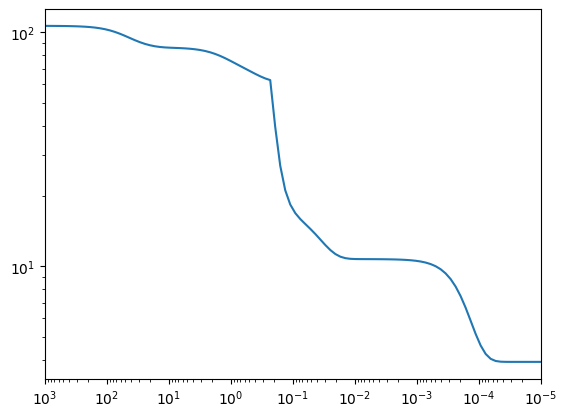

In [21]:
plt.loglog(Temp, np.array(Degr_SM))
plt.xlim(1e3, 1e-5)
plt.show()